In [122]:
import numpy as np
import matplotlib.pyplot as plt

# --- CONSTANTS ---

# States
ACE_STATES = 2
DEALER_STATES = 10
PLAYER_STATES = 1 + 10 + 1
STATES = PLAYER_STATES * DEALER_STATES * ACE_STATES

# Action related constants
ACTION_COUNT = 2
STAY = 0
HIT = 1

# Policy and Reward constants
GAMMA = 1	
EPSILON = 0

# Result constants
WIN = 1
DRAW = 0
LOSS = -1
LOSE_STATE = PLAYER_STATES - 1

# Runtime constants
CHECK_EVERY = 100000
CHECK_COUNT = 1000
RUN_PERIOD = 400000

In [123]:
# Contains an episode of data (state, action, reward)
class Episode:
    def __init__(self):
        self.state = []
        self.action = []
        self.reward = []

In [124]:
# Converts a hand of cards to corresponding state
def cards_to_state(cards, is_dealer=False):

    if is_dealer:
        return cards[0] - 1

    else:
        # Get the total of the cards
        sum = np.sum(cards)

        # If any card is an ace and sum is less than 12, ace is useable
        a_state = 1 if ( np.any(np.array(cards) == 1) and sum < 12 ) else 0

        # If ace is useable, set its value to 11 points
        if a_state:
            sum += 10

        # All sums less than 11 are treated as state 0
        # Sums 12-21 are mapped to states 1-10
        # Any sum above 21 is mapped to state 11
        p_state = np.maximum(0, np.minimum(PLAYER_STATES-1, sum - 11))

        return p_state, a_state

In [125]:
# Start a new game and deal 2 cards to player and dealer		
def deal_cards(random_start=False):

    # If random start flag is set, choose a random state with equal prob
    if random_start:
        d_state = np.random.randint(DEALER_STATES)
        p_state = np.random.randint(PLAYER_STATES-1)
        a_state = np.random.randint(ACE_STATES)

        # if has an ace
        if a_state:

            # if p_state == 0, ie p_cards sum < 12
            if p_state == 0:
                p_state = np.random.randint(1,11) # random card between 1 and 10

            p_cards = [1, p_state] # Ace and something else

        # if no ace
        else:

            # p_cards sum = p_state + 11
            p_cards = [p_state+1, 10]

        # exposed card is d_state+1, second card is random card between 1 and 10
        d_cards = [d_state+1, np.random.randint(1,11)]

    # Otherwise, choose state with prob based on an infinite deck
    else: 

        # create two random card (numbers between 1 and 13) for dealer and player
        d_cards = np.random.randint(1, 14, size=2)
        p_cards = np.random.randint(1, 14, size=2)

        # Values of cards 11-13 are all 10
        d_cards[d_cards > 10] = 10
        p_cards[p_cards > 10] = 10


        # Map the cards to the states
        d_state = cards_to_state(d_cards, is_dealer=True)
        p_state, a_state = 	cards_to_state(p_cards)

    return d_cards, p_cards, d_state, p_state, a_state

In [126]:
# Deal a single new card (suit doesnt matter, only value)
def deal_card():

    # generate a random number between 1-13; convert 11-13 to 10
    return np.minimum(10, np.random.randint(1, 14))

In [127]:
# Randomly decide to HIT or STAY with equal probability
def random_policy():

    # randomly decide to HIT or STAY
    return np.random.choice((STAY,HIT))



In [128]:
# Return the score of the hand given the cards
def get_score(cards, is_dealer=False):

    # Check if there's an ace in the hand
    has_ace = np.any( cards == 1 )

    # Get the sum of cards, with any ace as 11 points
    sum = np.sum(cards) + 10*(has_ace)

    # If has an ace, is a dealer and sum isnt blackjack, reduce ace to 1 point
    # If has an ace, isnt a dealer, and is BUST, reduce ace to 1 point
    if has_ace and ((is_dealer and sum != 21) or sum > 21):		
        sum = sum - 10

    return sum

In [129]:
# Run a single episode, either on a policy or with a random policy	
def run_episode(on_policy=False, policy=None, hard_policy=False):

    # Create an episode
    this_episode = Episode()

    # Deal out cards to start the game
    d_cards, p_cards, d_state, p_state, a_state = deal_cards(random_start=True)

    # print(f"Cards P/D {p_cards} / {d_cards}, States: {p_state, d_state, a_state}, START")

    # Use provided policy to get action if hard policy, or with prob EPSILON if soft
    if on_policy and ( np.random.rand() < EPSILON or hard_policy ) :
        action = policy[d_state, p_state, a_state]
    else:
        action = random_policy()

    # Store state and action in our episode
    this_episode.state.append((d_state, p_state, a_state))
    this_episode.reward.append(0)
    this_episode.action.append(action)

    is_bust = False

    # While the policy keeps coming up as HIT
    while action == HIT:

        # Draw a new card if the player chose to hit
        p_cards = np.append(p_cards, deal_card())	

        # Get the new state of the player
        p_state, a_state = cards_to_state(p_cards)

        # print(f"Cards P/D {p_cards} / {d_cards}, States: {p_state, d_state, a_state}, P HIT")

        # Append this new state to our episode
        this_episode.state.append((d_state, p_state, a_state))

        # if player is in the LOSE_STATE, give -1 reward and end episode
        if p_state == LOSE_STATE:
            this_episode.reward.append(-1)
            # print(f"Cards P/D {p_cards} / {d_cards}, States: {p_state, d_state, a_state}, BUST")
            return this_episode

        else:
            this_episode.reward.append(0)

        # Get the next action
        if on_policy and np.random.rand() < EPSILON:
            action = policy[d_state, p_state, a_state]
        else:
            action = random_policy()

        this_episode.action.append(action)


    # print(f"Cards P/D {p_cards} / {d_cards}, States: {p_state, d_state, a_state}, P STAY")

    # Since the last action was to STAY, the next state is same as curr state
    this_episode.state.append(this_episode.state[-1])

    # Get the current score of the dealer
    d_sum = get_score(d_cards, is_dealer=True)	

    # If the dealer's score is less than 17
    while d_sum < 17:
        # Draw a new car and get the new score
        d_cards = np.append(d_cards, deal_card())

        # print(f"Cards P/D {p_cards} / {d_cards}, States: {p_state, d_state, a_state}, D HIT")

        d_sum = get_score(d_cards, is_dealer=True)

    # print(f"Cards P/D {p_cards} / {d_cards}, States: {p_state, d_state, a_state}, D STAY")

    p_sum = get_score(p_cards)

    # If the dealer goes BUST or has less points than player, player wins
    if (d_sum > 21) or (p_sum > d_sum):
        this_episode.reward.append(1)
        # print(f"Cards P/D {p_cards} / {d_cards}, Scores: {p_sum, d_sum}, WIN")

    # Dealer and player have the same score, its a tie
    elif p_sum == d_sum:
        this_episode.reward.append(0)
        # print(f"Cards P/D {p_cards} / {d_cards}, Scores: {p_sum, d_sum}, TIE")

    # Player loses
    else:
        this_episode.reward.append(-1)
        # print(f"Cards P/D {p_cards} / {d_cards}, Scores: {p_sum, d_sum}, LOSS")

    return this_episode

In [130]:
# Run a bunch of episodes to check win-rate with provided policy
# If no policy is provided, a random policy will be used as baseline
def check_win_rate(on_policy=False, policy=None):

    wins = 0
    losses = 0
    games = CHECK_COUNT

    # For number of episodes to run check on
    for t in range(CHECK_COUNT):

        # Run an episode on hard policy
        episode = run_episode(on_policy=on_policy, policy=policy, hard_policy=True)

        # Keep running total of wins and losses
        wins += 1 if episode.reward[-1] == WIN else 0
        losses += 1 if episode.reward[-1] == LOSS else 0

    return 100.0*wins/games, 100.0*losses/games


In [131]:
# Plot the Q function and the current policy
def plot_Q_policy(Q, N, policy):

    fig, ax = plt.subplots(4,2)
    q_img = ax[0,0].imshow(Q[:,:-1,0,HIT] - Q[:,:-1,0,STAY], cmap='Set2', vmin=-2, vmax=2, aspect="auto", extent=[11, 21, 1, 10]) # ACE, POS if HIT, neg if STAY
    q_img = ax[1,0].imshow(Q[:,:-1,1,HIT] - Q[:,:-1,1,STAY], cmap='Set2', vmin=-2, vmax=2, aspect="auto", extent=[11, 21, 1, 10]) # NO ACE, POS if HIT, neg if STAY
    p_img = ax[0,1].imshow(policy[:,:,0], cmap='bwr', vmin=0, vmax=1, aspect="auto", extent=[11, 21, 1, 10])	# Useable Ace
    p_img = ax[1,1].imshow(policy[:,:,1], cmap='bwr', vmin=0, vmax=1, aspect="auto", extent=[11, 21, 1, 10])	# No Useable Ace
    n_img = ax[2,0].imshow(N[:,:-1,0,HIT], vmin=0, vmax=1000, aspect="auto")
    n_img = ax[2,1].imshow(N[:,:-1,0,STAY], vmin=0, vmax=1000, aspect="auto")
    n_img = ax[3,0].imshow(N[:,:-1,1,HIT], vmin=0, vmax=1000, aspect="auto")
    n_img = ax[3,1].imshow(N[:,:-1,1,STAY], vmin=0, vmax=1000, aspect="auto")    
    
    ax[0,0].set_ylabel("Dealer States")
    ax[1,0].set_ylabel("Dealer States")
    ax[1,0].set_xlabel("Player States")
    ax[1,1].set_xlabel("Player States")

    fig.colorbar(q_img, ax=ax.ravel().tolist())
    fig.colorbar(p_img, cmap='bwr', ax=ax.ravel().tolist())
    fig.colorbar(n_img, ax=ax.ravel().tolist())
    plt.show()



In [132]:
# Train a policy using Q function to learn from experience	
def main():

    # Initialize Q function and count of times any (S,A) pair has been encountered
    # Q = np.random.normal(loc=0.0, scale=0.01, size=(DEALER_STATES, PLAYER_STATES, ACE_STATES, ACTION_COUNT))
    Q = np.zeros((DEALER_STATES, PLAYER_STATES, ACE_STATES, ACTION_COUNT))
    N = np.zeros_like(Q)

    # The policy is the value action (A) for any given state (S) that maximizes Q(S,A)
    policy = np.argmax(Q, axis=3)

    episode_count = 1
    keep_training = True

    # Keep training until the user says to stop
    while keep_training:

        # print(f"Ran {episode_count} episodes")

        # Run an episode on a soft policy
        episode = run_episode(on_policy=True, policy=policy)

        # G is either WIN, TIE, or LOSS (1, 0, -1)
        G = episode.reward[-1]

        # Get the starting states and action, increment N(S,A)
        s1,s2,s3 = episode.state[0]
        a = episode.action[0]
        N[s1,s2,s3,a] += 1

        # Update Q(S,A) by averaging all G(S,A) seen so far (incremental update)
        Q[s1,s2,s3,a] += 0.01 * (G - Q[s1,s2,s3,a]) / N[s1,s2,s3,a]

        # Update the policy
        policy[s1,s2,s3] = np.argmax( Q[s1,s2,s3,:] )


        # Every so often, check current win and lose rate
        if episode_count % CHECK_EVERY == 0:
            EPSILON = 1 - 0.1**(episode_count/CHECK_EVERY)
            win_rate, lose_rate = check_win_rate(on_policy=True, policy=policy)
            print(f"Ran {episode_count} episodes, W/L: {win_rate:.2f} / {lose_rate:.2f}, eps: {EPSILON}")

        # Every so often, ask the user if they want to keep training
        if episode_count % RUN_PERIOD == 0:

            plot_Q_policy(Q, N, policy)

            # If the user presses n, stop, otherwise keep going
#             user_input = input("\nPress n to stop training, or anything else to keep going\n")
#             if user_input == "n":
#                 keep_training = False

        episode_count += 1

        # input("Press a key to continue\n\n")

    # Print final w/l rates
    win_rate, lose_rate = check_win_rate(on_policy=True, policy=policy)
    print(f"\n\n-------------------------------\nRan {episode_count} episodes, FINAL W/L: {win_rate:.2f} / {lose_rate:.2f}\n-------------------------------\n")
    plot_Q_policy(Q, N, policy)

Ran 100000 episodes, W/L: 40.20 / 54.90, eps: 0.9
Ran 200000 episodes, W/L: 38.50 / 56.40, eps: 0.99
Ran 300000 episodes, W/L: 42.80 / 51.10, eps: 0.999
Ran 400000 episodes, W/L: 42.10 / 53.40, eps: 0.9999


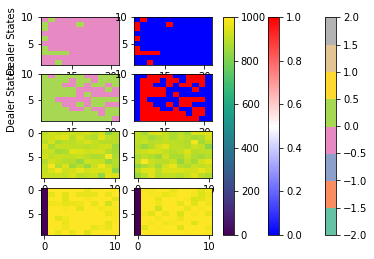

Ran 500000 episodes, W/L: 41.50 / 52.80, eps: 0.99999


KeyboardInterrupt: 

In [133]:
main()

In [137]:
if False: x = 5
elif False: x = 4
else: x = 3
    
x

3